In [2]:
using DifferentialEquations
using StochasticDelayDiffEq
using SpecialFunctions
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW
using CSV

In [3]:
# FUNCTIONS NEDEED FOR THE MODEL

# Box-shaped function for the magnetic field range 
function f(B, B_max = 10, B_min = 1)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
  end
  
  # Model function for the DDE
  function MagneticField(du, u, h, p, t)
    N, T, tau, sigma, Bmax = p
    q = T / tau
  
    B, dB = u
  
    du[1] = dB
    du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1], Bmax))
  end
  
  # Noise function for the DDE
  function noise!(du, u, h, p, t)
    N, T, tau, sigma, Bmax = p
    du[1] = (sigma * Bmax)
  end

noise! (generic function with 1 method)

In [4]:
# SIMULATED DATA PARAMETERS MANAGING

# Parameters for the simulated data
N = 6.2
T = 3.1
tau = 3.5
sigma = 0.04
B_max = 6.0

par = [N, T, tau, sigma, B_max]

# Time
tspan = (0, 1000)
dt = 0.01

# Initial conditions
B0 = [3.0, 0.0]
h0 = [0.0, 0.0]
noise0 = [1.0]

1-element Vector{Float64}:
 1.0

In [5]:
# DATA SIMULATION

# Data simulation with the chosen parameter
h(p, t) = h0
prob = SDDEProblem(MagneticField, noise!, B0, h, tspan, par)
sol = solve(prob, EM(), dt = dt)

# Important solution data that are necessary afterwards
t = sol.t
u = sol[1, :]
du = sol[2, :]

100002-element Vector{Float64}:
  0.0
 -0.0024489795918367346
 -0.004844732651539197
 -0.007194658657532802
 -0.00955785113548788
 -0.011938549217466234
 -0.014331894688275306
 -0.01670429713667997
 -0.01907780988386411
 -0.02143592883416489
  ⋮
 11.9461217767236
 11.848021608186576
 11.750381904300081
 11.653178213667541
 11.556441989798149
 11.46015353136092
 11.364282721887687
 11.268849303568103
 11.268849296306419

In [6]:
# Calcolo della trasformata di Fourier
u_fft = fft(u)

# Calcolo delle frequenze associate
n = length(u)
Fs = 1.0 / (n * dt)
freqs = fftfreq(n, 1/Fs)

# Trova l'indice della massima ampiezza nella trasformata di Fourier
abs_fft = abs.(u_fft)
max_amp_idx = argmax(abs_fft)
dominant_freq = freqs[max_amp_idx]

println("Frequenza dominante: ", dominant_freq)

Frequenza dominante: 0.29


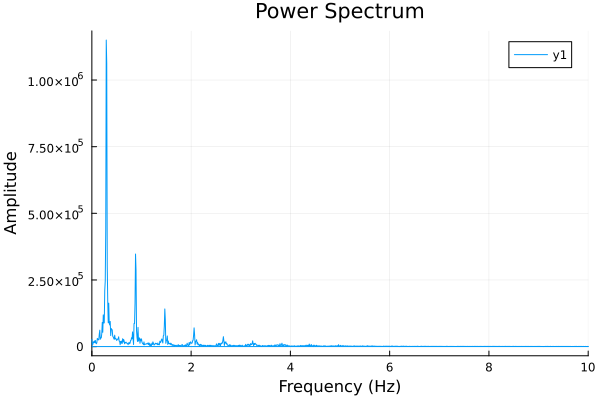

In [7]:
using Plots
plot(freqs, abs_fft, xlabel="Frequency (Hz)", ylabel="Amplitude", title="Power Spectrum", xlim=(0,10))

In [8]:
# Trova gli indici delle prime 4 ampiezze massime nel primo semicingolo delle frequenze positive
positive_indices = findall(x -> x >= 0, freqs)
max_indices = sortperm(abs_fft[positive_indices], rev=true)[1:100]
dominant_freqs = freqs[positive_indices][max_indices]
dominant_amps = abs_fft[positive_indices][max_indices]

println("Prime 100 Frequenze Dominanti Positive:")
for i in 1:100
    println("Frequenza: $(dominant_freqs[i]) Hz, Amplitude: $(dominant_amps[i])")
end

Prime 100 Frequenze Dominanti Positive:
Frequenza: 0.29 Hz, Amplitude: 1.1498876425520903e6
Frequenza: 0.3 Hz, Amplitude: 1.0613694604319893e6
Frequenza: 0.28 Hz, Amplitude: 438638.075308938
Frequenza: 0.88 Hz, Amplitude: 347200.09674041404
Frequenza: 0.31 Hz, Amplitude: 305330.16192239954
Frequenza: 0.89 Hz, Amplitude: 285942.84088741726
Frequenza: 0.27 Hz, Amplitude: 246662.40609421727
Frequenza: 0.26 Hz, Amplitude: 210834.55513684038
Frequenza: 0.32 Hz, Amplitude: 171262.53114429553
Frequenza: 0.87 Hz, Amplitude: 163269.77059951462
Frequenza: 0.34 Hz, Amplitude: 162929.1893286378
Frequenza: 1.47 Hz, Amplitude: 141221.62696237216
Frequenza: 0.23 Hz, Amplitude: 118985.79729330682
Frequenza: 1.48 Hz, Amplitude: 100409.8833480382
Frequenza: 0.37 Hz, Amplitude: 94206.36023460185
Frequenza: 0.21 Hz, Amplitude: 90667.5880678935
Frequenza: 0.33 Hz, Amplitude: 89582.54932613448
Frequenza: 0.25 Hz, Amplitude: 89087.058282718
Frequenza: 0.24 Hz, Amplitude: 88190.10516442462
Frequenza: 0.350000

In [10]:
freqs = [0.29, 0.88, 1.46, 2.05, 2.64, 3.22] 
indeces = round.(Int, freqs * n / (2π)) .+ 1
println(indeces)

[4617, 14007, 23238, 32628, 42019, 51250]


In [26]:
c=[]
for i in 1:length(indeces)-1
    b=indeces[i+1]-indeces[1]
    push!(c,b)
end
println(c)


Any[9390, 18621, 28011, 37402, 46633]
